# Finetuning BERT for Routing


BERT (Bidirectional Encoder Representations from Transformers) is one of the most popular small language models that be used for finetuning. It was a breakthrough model that was developed by Google and set new standards for understanding human language.
In this notebook I will use BERT with the huggingface PyTorch library to efficiently fine-tune a model to work as router. More specifically, I will create a binary classifier using the synthetic dataset we create. The architecture of the model can be exteneded to multilabel classification, in case we want to route between more models.

## Imports

In [6]:
# usual data analysis tools
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# popular general purpose libraries
from collections import Counter
import os
import datetime
import time
import json
from tabulate import tabulate
# import warnings
# warnings.filterwarnings("ignore")

# machine learning / tensor libraries
import torch
from torch import cuda
torch.cuda.empty_cache()
device = 'cuda' if cuda.is_available() else 'cpu'

from torch.utils.data import DataLoader, Dataset
from transformers import AutoTokenizer, BertForSequenceClassification, AdamW, BertConfig

# to save to google drive
from google.colab import drive

## Setting Hyperaparameters

This structure will control the basic aspects of training. Namely, which model will be used, epochs, batch size, learning rate, etc.



Throught the hugging face API, we can actually select between different variants of the BERT model. The original and most famous is the original [BERT](https://huggingface.co/docs/transformers/en/model_doc/bert) model (`google-bert/bert-base-uncased`). Other popular implementations are [DistilBERT](https://huggingface.co/docs/transformers/en/model_doc/distilbert) (`distilbert/distilbert-base-uncased`), [RoBERTa](https://huggingface.co/docs/transformers/en/model_doc/roberta) (`FacebookAI/roberta-base`, `distilbert/distilroberta-base`) and [DeBERTa](https://huggingface.co/docs/transformers/en/model_doc/deberta-v2).

In [7]:
HPARAMS = {
    'lr': 2e-6,
    'eps': 1e-8,
    'epochs': 4,
    'batch_size': 8,
    'hf_model_name': "bert-base-uncased",
    'make_balanced': True,
}

## Read Data

Let's load the data into dataframes and split into train, validation and test. Note that `make_balanced` and `max_length` input parameters control two major aspect of our data that will affect our training dataset and hence our model during finetuning.

In [8]:
# first dataset option
def import_df_from_jsonl_file(filepath):
    return pd.read_json(filepath, lines=True)

router_df = import_df_from_jsonl_file('router_dataset_all.jsonl')

def process_synthetic_dataset(df, make_balanced, max_length):
  tags2nums_dict={ "ROUTE_TO_INFERIOR": 0, "ROUTE_TO_SUPERIOR": 1 }
  df = df.drop_duplicates(subset='conversation_id', keep='first') # drop duplicate conversations
  df = df.rename(columns={'initial_prompt': 'text', 'gpt_content': 'label_tag'})
  df = df[df['label_tag'].isin(tags2nums_dict.keys())]
  df['target'] = df['label_tag'].map(tags2nums_dict)
  assert not df['target'].isna().any()
  if max_length > 0: # drop really large prompts
    mask = df.apply(lambda row: len(row['text']) < max_length, axis=1)
    df = df[mask]
  if make_balanced:
    count_0 = (df['target'] == 0).sum()
    count_1 = (df['target'] == 1).sum()
    count_min = min(count_0, count_1)
    df_0 = df[df['target'] == 0].sample(n=count_min, random_state=42)
    df_1 = df[df['target'] == 1].sample(n=count_min, random_state=42)
    df = pd.concat([df_0, df_1]).sample(frac=1).reset_index(drop=True) # combine and shuffle
  return df[['text', 'target']]

router_df = process_synthetic_dataset(router_df, make_balanced=HPARAMS['make_balanced'], max_length = 250)

print(Counter(router_df['target']))
router_df.head()


Counter({0: 2019, 1: 2019})


,text,target
0,write a email to congratulate new students adm...,0
1,Create a slide outline to show how I used a na...,1
2,"I will send you 10 transcriptions of videos, a...",0
3,What would be an affective thing to call a bla...,1
4,Can I use blktrace on an NVMe device loaded on...,1


In [9]:
original_df = import_df_from_jsonl_file('original_questions_labelled.jsonl')

def process_questions_dataset(df):
  tags2nums_dict={"ROUTE_TO_INFERIOR": 0,  "ROUTE_TO_SUPERIOR": 1 }
  df = df[df['label'] != "ROUTE_NOT"].dropna()
  df = df.rename(columns={'question': 'text'}).reset_index()
  df['target'] = df['label'].map(tags2nums_dict)
  assert not df['target'].isna().any()
  return df[['text', 'target']]

original_df = process_questions_dataset(original_df)

original_df.head()


,text,target
0,Compose an engaging travel blog post about a r...,1
1,Imagine you are writing a blog post comparing ...,0
2,Write a descriptive paragraph about a bustling...,1
3,Could you write a captivating short story begi...,1
4,Craft an intriguing opening paragraph for a fi...,0


In [10]:
trainvalid_data = router_df
test_data = original_df

In [11]:
trainvalid_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4038 entries, 0 to 4037
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    4038 non-null   object
 1   target  4038 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 63.2+ KB


In [12]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    60 non-null     object
 1   target  60 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 1.1+ KB


In [13]:
trainvalid_data.isna().sum()

text      0
target    0
dtype: int64

In [14]:
test_data.isna().sum()

text      0
target    0
dtype: int64

We are only interest in two columns `text` and `target`. Both do not contain any missing values.

In [15]:
# Only choose relevant columns
trainvalid_data = trainvalid_data[['text', 'target']]
test_data = test_data[['text', 'target']]

## EDA

In this section, I analyse the input data to understand how theyy can impact the results of our model.
This part is pretty straightforward since we just have two columns. One with the actual text and another with the label.

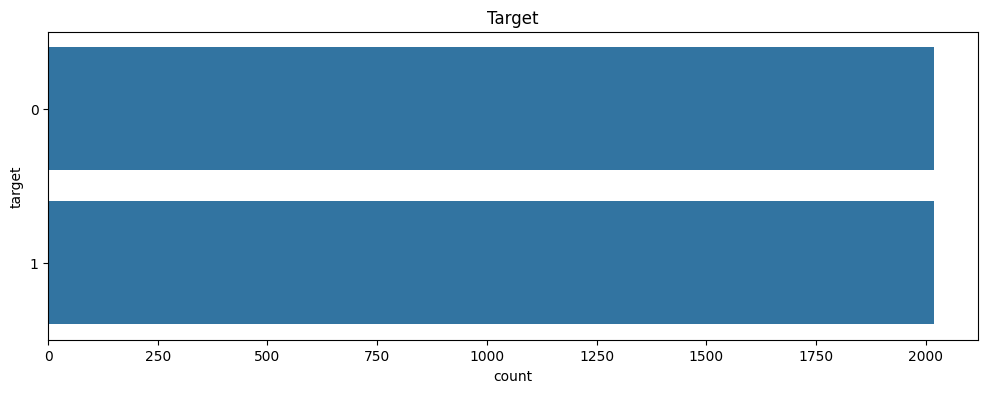

In [16]:
plt.figure(figsize=(12, 4))
sns.countplot(y=trainvalid_data['target'])
plt.title('Target')
plt.show()

Of course, we only have two classes 0 and 1. The classes can be balanced or a bit unbalanced, depending on the flag `make_balanced` in the original parsing function of the dataset. Essentially, we can control this aspect and check the results of our model.

BERT has a max length limit of 512 tokens. So only 512 "words" can be feed into BERT. In the next step we will check the amount of tokens per prompt. We can control this aspcect of our data using the `max_length` input parameter in our parsing function.

<ipython-input-17-21b87556e808>:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(trainvalid_data['WordLength'])


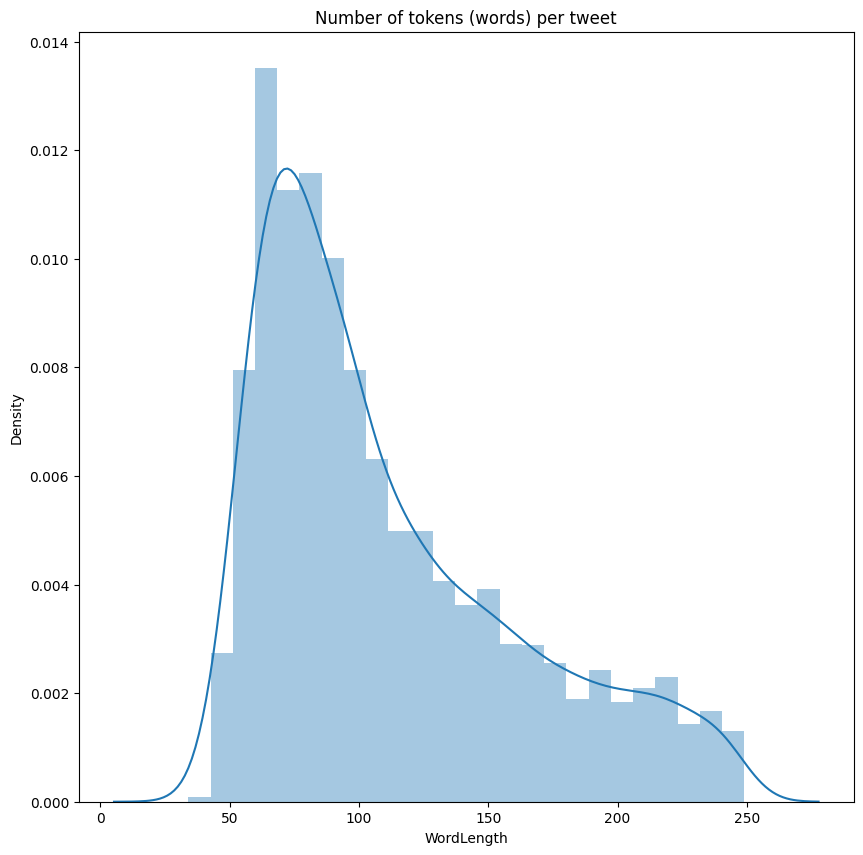

In [17]:
trainvalid_data['WordLength'] = trainvalid_data['text'].str.len()
fig = plt.figure(figsize=(10,10))
sns.distplot(trainvalid_data['WordLength'])
plt.title('Number of tokens')
plt.show()

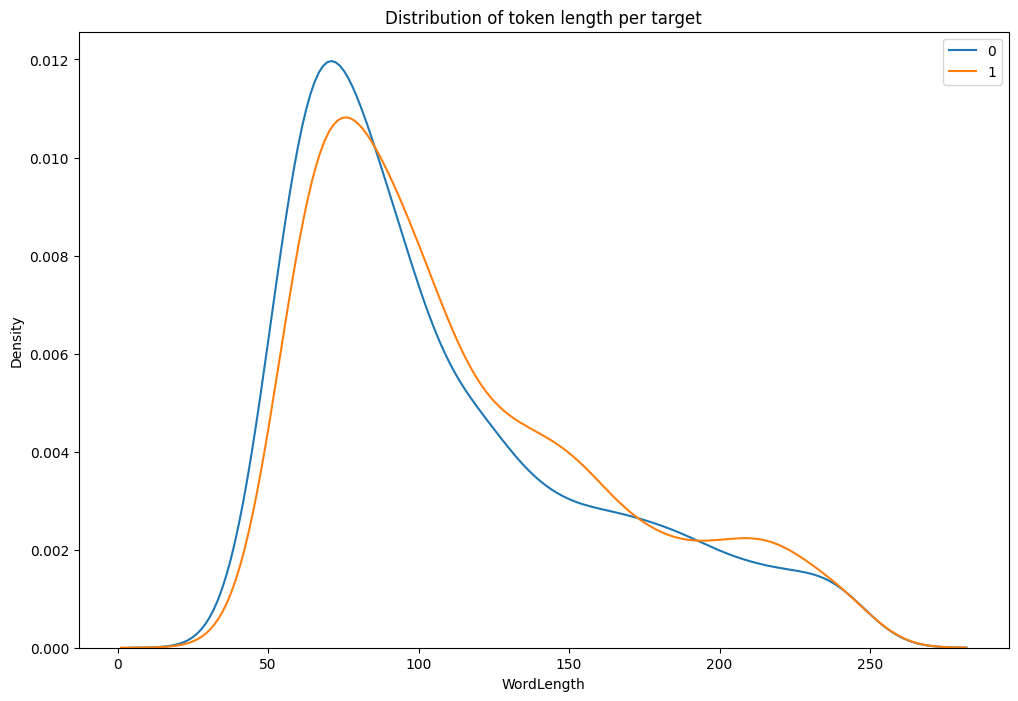

In [18]:
fig, ax = plt.subplots(figsize=(12,8))
for sentiment in [0, 1]:
    sns.kdeplot(trainvalid_data[trainvalid_data['target']==sentiment]['WordLength'],ax=ax, label=sentiment)
ax.legend()
ax.set_title('Distribution of token length per target')
plt.show()

## Dataset Class

In this section, we create a Dataset class that is going to be used to
The Dataset class in PyTorch is a key component of the data loading pipeline. It provides an abstraction for accessing and manipulating your data during the training or testing phase of your machine learning model. It provides data encapsulation and seamless integration with data loaders. It also provides flexibility, memory efficiency and compatibility with PyTorch ecosystem.

In [19]:
HF_MODEL_NAME = HPARAMS['hf_model_name']

In [20]:
class TextDataset(Dataset):
    def __init__(self, dataframe, max_length=512, tokenizer_name="bert-base-uncased"):
        self.texts = dataframe['text'].values
        self.targets = dataframe['target'].values
        self.tokenizer = AutoTokenizer.from_pretrained(tokenizer_name)
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        target = self.targets[idx]
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        input_ids = encoding['input_ids'].flatten()
        attention_mask = encoding['attention_mask'].flatten()

        return {
            'input_ids': torch.as_tensor(input_ids, dtype=torch.long),
            'attention_mask': torch.as_tensor(attention_mask, dtype=torch.long),
            'targets': torch.as_tensor(target, dtype=torch.long),
            'text': text
        }

A lot is going on here. So let´s go through the code above. We have three functions within our `TextDataset` object. `__init__()` is our constructor. Nothing special in here. We just define our texts and targets, as well as the tokenzier.

You have to provide at least two additional functions:
- `__len()__`: method is expected to return the size of the dataest, i.e. the total number of items it contains. This information is crucial for several reasons:
    - Iteration: It allows PyTorch to know the size of the dataset for iterating over it. This is particularly useful in scenarios where you want to loop through the dataset, as it defines the loop's stopping criterion.
    - Batching: In the context of mini-batch gradient descent, knowing the dataset size is essential to calculate the number of batches per epoch.
    - Index Validation: It provides a way to validate index values in the `__getitem()__` method, ensuring they are within the valid range (0 to dataset size - 1).
- `__getitem()__` method allows the dataset to act like a list (or a map), enabling it to fetch data items by indices. When you implement this method, it should:
    - Accept an index (integer) as an argument.
    - Fetch the data item (in our case the content and target) corresponding to the given index.
    - Perform any required preprocessing or data augmentation on the data item (in our case - tokenization)
    - Return a data sample, typically as a tuple (features, label) - in our case a dictionary
    
    
The most magic work happens within the `__getitem()__` method. To feed our text to BERT, it must be split into tokens, and then these tokens must be mapped to their index in the tokenizer vocabulary. While tokenization we are required to:
- Add special tokens to the start and end of each sentence
- Pad & truncate all sentences to a single constant length
- Explicity differentiate real tokens from padding tokens with the attention mask

## Validation Split And Preparing Datasets
We will divice our dataset into a train set and test set. 90% should be used for training and the rest for evaluation. We also use the original test questions from the previous notebook for classification.

In [21]:
train_data, valid_data = train_test_split(trainvalid_data, train_size=0.9, shuffle=True, random_state=1702)
print(f'{len(train_data):>5,} Training samples')
print(f'{len(valid_data):>5,} Validation samples')

3,634 Training samples
  404 Validation samples


In [22]:
# Create custom Datasets
train_dataset = TextDataset(train_data, tokenizer_name=HF_MODEL_NAME)
valid_dataset = TextDataset(valid_data, tokenizer_name=HF_MODEL_NAME)
test_dataset = TextDataset(test_data, tokenizer_name=HF_MODEL_NAME)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


We will make the new directory to save all the data we need for this run.

In [23]:

drive.mount('/content/drive')
drive_path = '/content/drive/MyDrive/Colab Notebooks/saves'

# define a function with a naming convention for this dataset that we created
def get_isolike_time():
    today = datetime.datetime.today()
    isolike_time = today.strftime("%Y%m%dT%H%M%S")
    return isolike_time

save_directory = f"{drive_path}/{HF_MODEL_NAME}-router-finetuning-{get_isolike_time()}-save"
os.makedirs(save_directory)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [24]:
train_data.to_json(f"{save_directory}/train_data.jsonl", orient='records', lines=True)
valid_data.to_json(f"{save_directory}/valid_data.jsonl", orient='records', lines=True)
test_data.to_json(f"{save_directory}/test_data.jsonl", orient='records', lines=True)

In [25]:
with open(f"{save_directory}/hparams.jsonl", 'w') as fp:
    json.dump(HPARAMS, fp)


We will also create an iterator for our datasets using the PyTorch <tt>DataLoader</tt> class. This helps save on memory during training because, unlike a foor loop, with an iterator the entire dataset does not need to be loaded into memory.

The <tt>DataLoader</tt> needs to know our batch size for training. It is recommented to use a batch size of 16 or 32. We will take the training samples in a random order. For better reproducibility we set a random seed. For the validation loader we set the batchsize equal to the length of it because there is no need to batch the data.

In [26]:
BATCH_SIZE = HPARAMS['batch_size']

In [27]:
torch.manual_seed(1702)

train_loader = DataLoader(train_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=True)

valid_loader = DataLoader(valid_dataset,
                         batch_size=BATCH_SIZE)

test_loader = DataLoader(test_dataset,
                         batch_size=BATCH_SIZE)
next(iter(train_loader))

{'input_ids': tensor([[ 101, 2689, 1996,  ...,    0,    0,    0],
         [ 101, 2064, 2017,  ...,    0,    0,    0],
         [ 101, 4339, 2033,  ...,    0,    0,    0],
         ...,
         [ 101, 2085, 1010,  ...,    0,    0,    0],
         [ 101, 2017, 2024,  ...,    0,    0,    0],
         [ 101, 7632, 1999,  ...,    0,    0,    0]]),
 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         ...,
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0]]),
 'targets': tensor([0, 0, 0, 1, 0, 0, 1, 1]),
 'text': ['Change the tone of the following sentence in the same language to sound casual and polite without missing out any facts or adding new information, "Sir can you calm down." .',
  'can you write a summary of about 200 words of a scientific article?',
  'write me a HTML that shows bouncing NAME_1 in a box',
  'give me 3 english words 5 letters lenght wh

From the [BertTokenizer docs](https://huggingface.co/docs/transformers/v4.42.0/en/model_doc/bert#transformers.BertTokenizer), we can learn about the special tokens. In the previous output, we can view the `input_ids` tensor, which is contains `batch_size` rows and each row contains `512` tokens. All rows start with the `[CLS]`. All rows have to be aligned, so append most of the rows with the `[PAD]` token. Other speical tokens for BERT are `[SEP]`, `[UNK]` and `[MASK]`. The `attention_mask` is simply an array of `0`s (for non-pad) and `1`s (for `PAD` token).

More about special tokens:
* `[UNK]` — The unknown token. A token that is not in the vocabulary cannot be converted to an ID and is set to be this token instead.
* `[SEP]` — The separator token, which is used when building a sequence from multiple sequences, e.g. two sequences for sequence classification or for a text and a question for question answering. It is also used as the last token of a sequence built with special tokens.
* `[PAD]` — The token used for padding, for example when batching sequences of different lengths.
* `[CLS]` — The classifier token which is used when doing sequence classification (classification of the whole sequence instead of per-token classification). It is the first token of the sequence when built with special tokens.
* `[MASK]` — The token used for masking values. This is the token used when training this model with masked language modeling. This is the token which the model will try to predict.


In [28]:
sample_input_ids = next(iter(train_loader))['input_ids']
print(f"Batches, length of each sentance: {sample_input_ids.size()}")


Batches, length of each sentance: torch.Size([8, 512])


## Load Model

Now the input ut properly formated, we can finally fine tune the BERT model. I will use <tt>BertForSequenceClassification</tt>. This is the normal BERT model with an added single linear layer on top for classification that we will use as a sentence classifier.

Also I check if a GPU is avaiable because training is much faster on it.

In [29]:
model = BertForSequenceClassification.from_pretrained(
    HF_MODEL_NAME,
    num_labels = 2,
    output_attentions = False,
    output_hidden_states = False,
)

model.to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

---

## Optimizer and Learning Rate

Now that we have our model loaded we need to specify hyperparameter for training.

According to the official paper [BERT: Pre-training of Deep Bidirectional Transformers for
Language Understanding](https://arxiv.org/pdf/1810.04805.pdf) we should choose the following values:
- <b>Batch size:</b> 16, 32
- <b>Learning Rate (Adam):</b> 5e-5, 3e-5, 2e-5
- <b>Number of epochs:</b> 2, 3, 4

According to [Gentle Introduction to the Adam Optimization Algorithm for Deep Learning](https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/) we have to specify a very small number to the epsilon parameter to prevent any division by zero in the implementation.

In [30]:
EPOCHS = HPARAMS['epochs']

optimizer = AdamW(model.parameters(),
                  lr = HPARAMS['lr'],
                  eps = HPARAMS['eps'])

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


---

## Training and Validation

A lot is going on here. So let´s quickly go through each step of the training process.

<b> Training Phase</b>
1. <b>Initialize Tracking Variables:</b> `training_stats`, `epoch_loss_train`, and `total_t0` are initialized to track the training progress, loss per epoch, and total training time, respectively.

2. <b>Epoch Loop:</b> A loop is started to iterate through each epoch. An epoch is one complete pass through the entire training dataset.

3. <b>Set Model to Training Mode:</b> `model.train()` puts the model in "training" mode, enabling features like dropout and batch normalization specific to training.

4. <b>Time Tracking for Epoch:</b> `t0` is recorded to track the time taken for each epoch.

5. <b>Batch Loop:</b> Iterates over each batch of data in `train_loader`. For each batch:

    5.1 <b>Time Check:</b> Every 40 steps, it prints the time elapsed since the start of the epoch.
    
    5.2 <b>Data Preparation:</b> Targets (labels), attention masks, and input IDs are loaded onto the appropriate device (CPU/GPU).
    
    5.3 <b>Gradient Zeroing:</b> `model.zero_grad()` clears old gradients; necessary because gradients accumulate by default for each `.backward()` call.
    
    5.4 <b>Forward Pass:</b> The model computes the forward pass with the given inputs and calculates the loss.
    
    5.5 <b>Tracking Loss and Predictions:</b> Loss is added to `epoch_loss_train`. Predictions are extracted from logits, and both predictions and true labels are stored for metric calculations.
    
    5.6 <b>Backward Pass and Optimization Step:</b> `loss.backward()` computes the gradient of the loss w.r.t. the model parameters, and `optimizer.step()` updates the model parameters.
    
6. <b>Metrics Calculation:</b> After processing all batches, calculate accuracy, precision, recall, and F1 score for the training data using `accuracy_score` and `precision_recall_fscore_support` from `sklearn.metrics`.

7. <b>Print Training Metrics:</b> Print loss and calculated metrics for the epoch.

<br>
<br>
<b> Validation Phaes</b>

1. <b>Set Model to Evaluation Mode:</b> `model.eval()` puts the model in "evaluation" mode, disabling training-specific features like dropout.

2. <b>Loss Tracking:</b> Initializes `epoch_loss_test` to track the validation loss.

3. <b>Batch Loop (Validation Data):</b> Iterates over each batch in `valid_loader`. For each batch:

    3.1 <b>Data Preparation:</b> Similar to the training loop, prepares targets, attention masks, and input IDs.
    
    3.2 <b>Forward Pass Without Gradient Calculation:</b> `with torch.no_grad()` disables gradient calculations, reducing memory usage and speeding up computations.
    
    3.3 <b>Tracking Loss and Predictions:</b> Similar to the training phase but for validation data.
    
4. <b>Metrics Calculation:</b> Calculates accuracy, precision, recall, and F1 score for the validation data.

5. <b>Print Validation Metrics:</b> Print validation loss and calculated metrics.

6. <b>Update Training Stats:</b> Appends a dictionary with training and validation metrics for the current epoch to `training_stats` for later analysis or reporting.


In [31]:
def get_metrics_and_loss(model, data_loader):
    model.eval()
    epoch_loss_test = []
    test_all_predictions = []
    test_all_true_labels = []
    for data in data_loader:
        targets = data["targets"].to(device)
        mask = data["attention_mask"].to(device)
        ids = data["input_ids"].to(device)

        with torch.no_grad():
            loss, logits = model(ids, token_type_ids=None, attention_mask=mask, labels=targets).to_tuple()

        epoch_loss_test.append(loss.item())
        cpu_logits = logits.cpu().detach().numpy()
        test_all_predictions.extend(np.argmax(cpu_logits, axis=1).flatten())
        test_all_true_labels.extend(targets.cpu().numpy())
    model.train()
    test_accuracy = accuracy_score(test_all_true_labels, test_all_predictions)
    test_precision, test_recall, test_f1, _ = precision_recall_fscore_support(
        test_all_true_labels, test_all_predictions, average="binary"
    )
    metrics = {
        "loss": np.mean(epoch_loss_test),
        "accuracy": test_accuracy,
        "precision": test_precision,
        "recall": test_recall,
        "f1": test_f1
    }
    return metrics

In [32]:
def print_metrics(d):
    print(tabulate(d.items(), headers = ["Metric", "Value"]))


In [33]:
print('---PRETRAINING VALIDATION METRICS---')
pretraining_valid_metrics = get_metrics_and_loss(model, valid_loader)
print_metrics(pretraining_valid_metrics)

print("")
print('---PRETRAINING TEST METRICS---')
pretraining_test_metrics = get_metrics_and_loss(model, test_loader)
print_metrics(pretraining_test_metrics)



---PRETRAINING VALIDATION METRICS---
Metric        Value
---------  --------
loss       0.701099
accuracy   0.480198
precision  0.488722
recall     0.31401
f1         0.382353

---PRETRAINING TEST METRICS---
Metric        Value
---------  --------
loss       0.68837
accuracy   0.466667
precision  0.724138
recall     0.466667
f1         0.567568


As we expected, the accuracy is around 50%, because currently it's a random guess. Now, we are going to optimise the model with our dataset and see the loss falling. We are going to stop at the point where the validation loss does not fall anymore.

In [34]:

training_stats = []
epoch_loss_train = []
total_t0 = time.time()

# TRAINING
for epoch in range(1, EPOCHS + 1):
    model.train()
    t0 = time.time()
    print("")
    print(f"================ Epoch {epoch} / {EPOCHS} ================")
    train_all_predictions = []
    train_all_true_labels = []
    for step, data in enumerate(train_loader):
        if step % 40 == 0 and not step == 0:
            elapsed = int(round(time.time() - t0))
            elapsed = str(datetime.timedelta(seconds=elapsed))
            print(f"  Batch {step:>5,}  of  {len(train_loader):>5,}.    Elapsed: {elapsed:}.")

        targets = data["targets"].to(device)
        mask = data["attention_mask"].to(device)
        ids = data["input_ids"].to(device)

        model.zero_grad()

        loss, logits = model(
            ids, token_type_ids=None, attention_mask=mask, labels=targets
        ).to_tuple()
        epoch_loss_train.append(loss.item())

        cpu_logits = logits.cpu().detach().numpy()
        train_all_predictions.extend(np.argmax(cpu_logits, axis=1).flatten())
        train_all_true_labels.extend(targets.cpu().numpy())

        loss.backward()
        optimizer.step()

    train_accuracy = accuracy_score(train_all_true_labels, train_all_predictions)
    train_precision, train_recall, train_f1, _ = precision_recall_fscore_support(
        train_all_true_labels, train_all_predictions, average="binary"
    )
    # TRAIN METRICS
    train_metrics = {
        "loss": np.mean(epoch_loss_train),
        "accuracy": train_accuracy,
        "precision": train_precision,
        "recall": train_recall,
        "f1": train_f1
    }
    print("")
    print('---TRAIN METRICS---')
    print_metrics(train_metrics)

    # VALIDATION METRICS
    valid_metrics = get_metrics_and_loss(model, valid_loader)
    print("")
    print('---VALIDATION METRICS---')
    print_metrics(valid_metrics)

    training_stats.append(
        {
            'epoch': epoch,
            'Training Loss': train_metrics['loss'],
            'Training Accuracy': train_metrics['accuracy'],
            'Training Precision': train_metrics['precision'],
            'Training Recall': train_metrics['recall'],
            'Training F1': train_metrics['f1'],
            'Validation Loss': valid_metrics['loss'],
            'Validation Accuracy': valid_metrics['accuracy'],
            'Validation Precision': valid_metrics['precision'],
            'Validation Recall': valid_metrics['recall'],
            'Validation F1': valid_metrics['f1']
        }
    )


================ Epoch 1 / 4 ================
  Batch    40  of    455.    Elapsed: 0:00:12.
  Batch    80  of    455.    Elapsed: 0:00:25.
  Batch   120  of    455.    Elapsed: 0:00:37.
  Batch   160  of    455.    Elapsed: 0:00:50.
  Batch   200  of    455.    Elapsed: 0:01:02.
  Batch   240  of    455.    Elapsed: 0:01:14.
  Batch   280  of    455.    Elapsed: 0:01:26.
  Batch   320  of    455.    Elapsed: 0:01:38.
  Batch   360  of    455.    Elapsed: 0:01:50.
  Batch   400  of    455.    Elapsed: 0:02:02.
  Batch   440  of    455.    Elapsed: 0:02:15.

---TRAIN METRICS---
Metric        Value
---------  --------
loss       0.673582
accuracy   0.580903
precision  0.581592
recall     0.568433
f1         0.574937

---VALIDATION METRICS---
Metric        Value
---------  --------
loss       0.666849
accuracy   0.59901
precision  0.590361
recall     0.710145
f1         0.644737

================ Epoch 2 / 4 ================
  Batch    40  of    455.    Elapsed: 0:00:12.
  Batch    80  o

We can now have a closer look at the statistic.

In [35]:
df_statistics = pd.DataFrame(data=training_stats)
df_statistics = df_statistics.set_index('epoch')
df_statistics

,Training Loss,Training Accuracy,Training Precision,Training Recall,Training F1,Validation Loss,Validation Accuracy,Validation Precision,Validation Recall,Validation F1
epoch,,,,,,,,,,
1,0.673582,0.580903,0.581592,0.568433,0.574937,0.666849,0.599010,0.590361,0.710145,0.644737
2,0.650997,0.658778,0.672289,0.615894,0.642857,0.665202,0.608911,0.596838,0.729469,0.656522
3,0.631950,0.694551,0.708929,0.657285,0.682131,0.658275,0.626238,0.621739,0.690821,0.654462
4,0.613430,0.720969,0.736936,0.684879,0.709954,0.655544,0.646040,0.645455,0.685990,0.665105


Let´s visualize the accuracy both for training and validation.

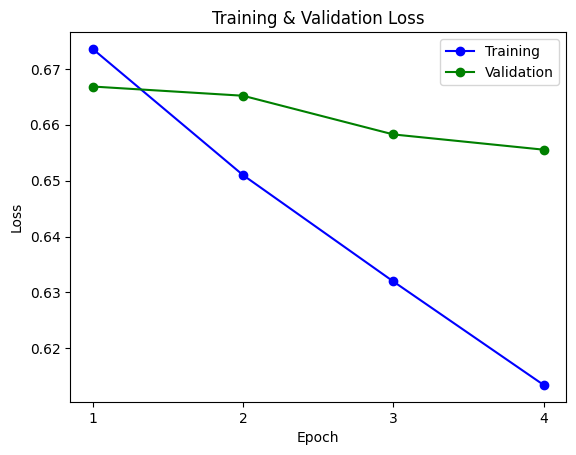

In [36]:
plt.plot(df_statistics['Training Loss'], 'b-o', label='Training')
plt.plot(df_statistics['Validation Loss'], 'g-o', label='Validation')
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks(list(range(1, EPOCHS+1)))
plt.savefig(os.path.join(save_directory, 'train_valid_loss_plot.png'))
plt.show()

## Save model run, hyperparameters, data, ...

In [37]:
# tokenizer.save_pretrained(save_directory) # bert-base-uncased
model.save_pretrained(save_directory)

In [38]:
df_statistics.to_json(f"{save_directory}/trainvalid_statistics.jsonl", orient='records', lines=True)

---

## Testing original dataset

The last step we have to apply our model to the *real* test data. We have to bring the data into the same structure as we did for the training. Therefore we need to create another <tt>Dataset</tt> class.

In [39]:
test_data.head()

,text,target
0,Compose an engaging travel blog post about a r...,1
1,Imagine you are writing a blog post comparing ...,0
2,Write a descriptive paragraph about a bustling...,1
3,Could you write a captivating short story begi...,1
4,Craft an intriguing opening paragraph for a fi...,0


Technically we could use one custom dataest with modifications. We would need one more variable called `mode` to handle the process for train and test sets. Test set has no `target` column. I just copied the dataest and modified it.

In [40]:
preds = []
for data in test_loader:
    mask = data["attention_mask"].to(device)
    ids = data["input_ids"].to(device)
    with torch.no_grad():
        logits = model(ids, token_type_ids=None, attention_mask=mask)[0]
        logits = logits.detach().cpu().numpy()
        flat_predictions = np.argmax(logits, axis=1).flatten()
        preds.extend(flat_predictions)

In [41]:
print(f"preds={Counter(preds)}")

preds=Counter({1: 39, 0: 21})


In [42]:
# TESTING ON ORIGINAL QUESTIONS
test_metrics = get_metrics_and_loss(model, test_loader)
print('---TEST METRICS---')
print_metrics(test_metrics)

with open(f"{save_directory}/test_metrics.jsonl", 'w') as fp:
    json.dump(test_metrics, fp)


---TEST METRICS---
Metric        Value
---------  --------
loss       0.500418
accuracy   0.733333
precision  0.837209
recall     0.8
f1         0.818182


When `make_balanced = False`, the model has recall that approaches 1, thus `false_negatives` approach 0. This means that the model tends to classify data with `ROUTE_TO_SUPERIOR` label. This is to be expected since the dataset is imbalanced and has more instances of `ROUTE_TO_SUPERIOR`.

When `make_balanced = True`, we observe a bit worse accuracy, but the model is now much more balanced with it's predictions. We achieve a performance of around 75%, which means that the model has actually managed to learn from the data and has achieved a good level of understanding of what prompts are easy vs hard and where should they be routed.

The reason that the model has not achieved so good results in the training/validation datasets is because the classification levels between the prompts are inherently more difficult. Remember that these data have been produced in an automated manner and the levels of difficulty varies a lot.
In contrast, in the test dataset, we have removed questions with label `ROUTE_NOT`, because there was no agreement between humans on which models answered better.

## Loading model and Inference

In this section, I'm showing the way to load the saved model for future use.

In [43]:
loaded_model = BertForSequenceClassification.from_pretrained(save_directory)
loaded_model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [44]:
# TESTING AGAIN ON ORIGINAL QUESTIONS WITH LOADED MODEL
test_metrics = get_metrics_and_loss(loaded_model, test_loader)
print('---TEST METRICS---')
print_metrics(test_metrics)


---TEST METRICS---
Metric        Value
---------  --------
loss       0.500418
accuracy   0.733333
precision  0.837209
recall     0.8
f1         0.818182


Now for inference, we create a new dataset accessor that takes as input a dataframe of only one column `text` (this time, the data contain no `target`)

In [45]:
data = [
    "Compose an engaging travel blog post about a recent trip to Hawaii, highlighting cultural experiences and must-see attractions.",
    "Which word does not belong with the others?\ntyre, steering wheel, car, engine",
    "Help me construct a catchy, yet scientifically accurate, headline for an article on the latest discovery in renewable bio-energy, while carefully handling the ethical dilemmas surrounding bio-energy sources. Propose 4 options."
]

In [46]:
# similar to the previous definition of dataset, without the target
class InferenceDataset(Dataset):
    def __init__(self, dataframe, max_length=512, tokenizer_name='bert-base-uncased'):
        self.texts = dataframe['text'].values
        self.tokenizer = AutoTokenizer.from_pretrained(tokenizer_name)
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        input_ids = encoding['input_ids'].flatten()
        attention_mask = encoding['attention_mask'].flatten()

        return {
            'input_ids': torch.as_tensor(input_ids, dtype=torch.long),
            'attention_mask': torch.as_tensor(attention_mask, dtype=torch.long),
        }

In [47]:
inference_data = pd.DataFrame({'text': data})

inference_dataset = InferenceDataset(inference_data, tokenizer_name=HF_MODEL_NAME)

inference_loader = DataLoader(inference_dataset, batch_size=8)

In [48]:
def inference(model, data_loader):
    predictions = []
    for data in data_loader:
        mask = data["attention_mask"].to(device)
        ids = data["input_ids"].to(device)
        with torch.no_grad():
            logits = model(ids, token_type_ids=None, attention_mask=mask)[0]
            logits = logits.detach().cpu().numpy()
            flat_predictions = np.argmax(logits, axis=1).flatten()
            predictions.extend(flat_predictions)
    return predictions

In [49]:
predictions = inference(loaded_model, inference_loader)
print(f"{predictions=}")

predictions=[1, 0, 1]


END OF PROJECT